In [6]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

import sys
import os
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [7]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (11,6),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [8]:
import torch
from sklearn.manifold import TSNE
import seaborn as sns

In [9]:
import pyarrow.dataset as ds
import pyarrow.feather as feather

In [10]:
from project.datasets import Dataset, CTRPDataModule
from project.models import MultiFiLMNetwork, ConcatNetwork

In [79]:
def prepare(exp, subset=True):
    data_path = Path("../../film-gex-data/processed/")
    input_cols = joblib.load(data_path.joinpath("gene_cols.pkl"))
    
    if exp=='id':
        cpd_id = "master_cpd_id"
        cond_cols = np.array([cpd_id, 'cpd_conc_umol'])
    else:
        fp_cols = joblib.load(data_path.joinpath("fp_cols.pkl"))
        cond_cols = np.append(fp_cols, ['cpd_conc_umol'])
        
    if subset:
        dataset = ds.dataset(data_path.joinpath("train_sub.feather"), format='feather')
    else:
        dataset = ds.dataset(data_path.joinpath("train.feather"), format='feather')

    return dataset, input_cols, cond_cols

## Full Data Stats

In [12]:
data_path = Path("../../film-gex-data/processed/")
full_ds = ds.dataset(data_path.joinpath("train_sub.feather"), format='feather')
full_data = full_ds.to_table().to_pandas()

In [ ]:
for c in full_data.columns: print(c, full_data[c].nunique())
print(full_data.shape)
del full_data

In [80]:
ds_path = Path("../../film-gex-data/drug_screens/")
ctrp = pd.read_csv(ds_path.joinpath("CTRP/v20.data.per_cpd_post_qc.txt") ,sep='\t', index_col=0)

/srv/home/wconnell/anaconda3/envs/lightning/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<AxesSubplot:xlabel='cpd_conc_umol'>

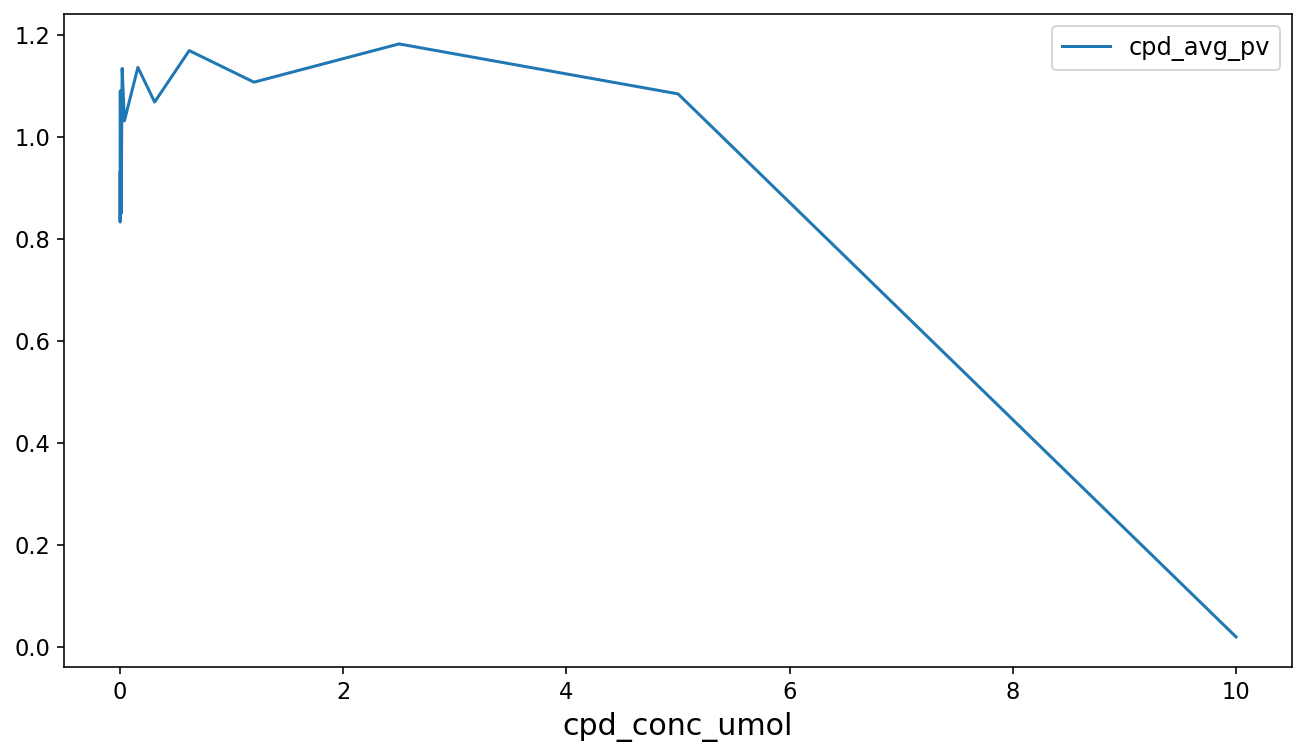

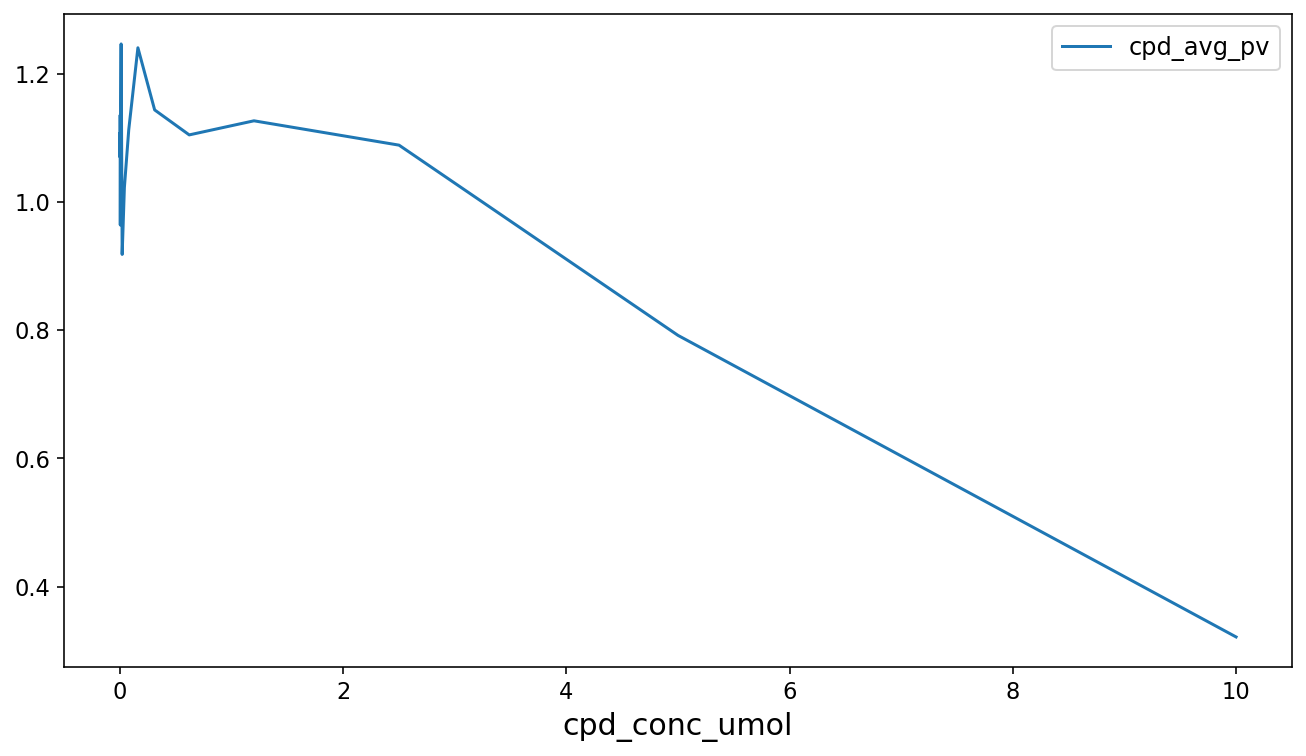

In [31]:
ctrp[ctrp['master_cpd_id']==1788].loc[1].plot('cpd_conc_umol', 'cpd_avg_pv')
ctrp[ctrp['master_cpd_id']==1788].loc[10].plot('cpd_conc_umol', 'cpd_avg_pv')

<AxesSubplot:xlabel='cpd_conc_umol'>

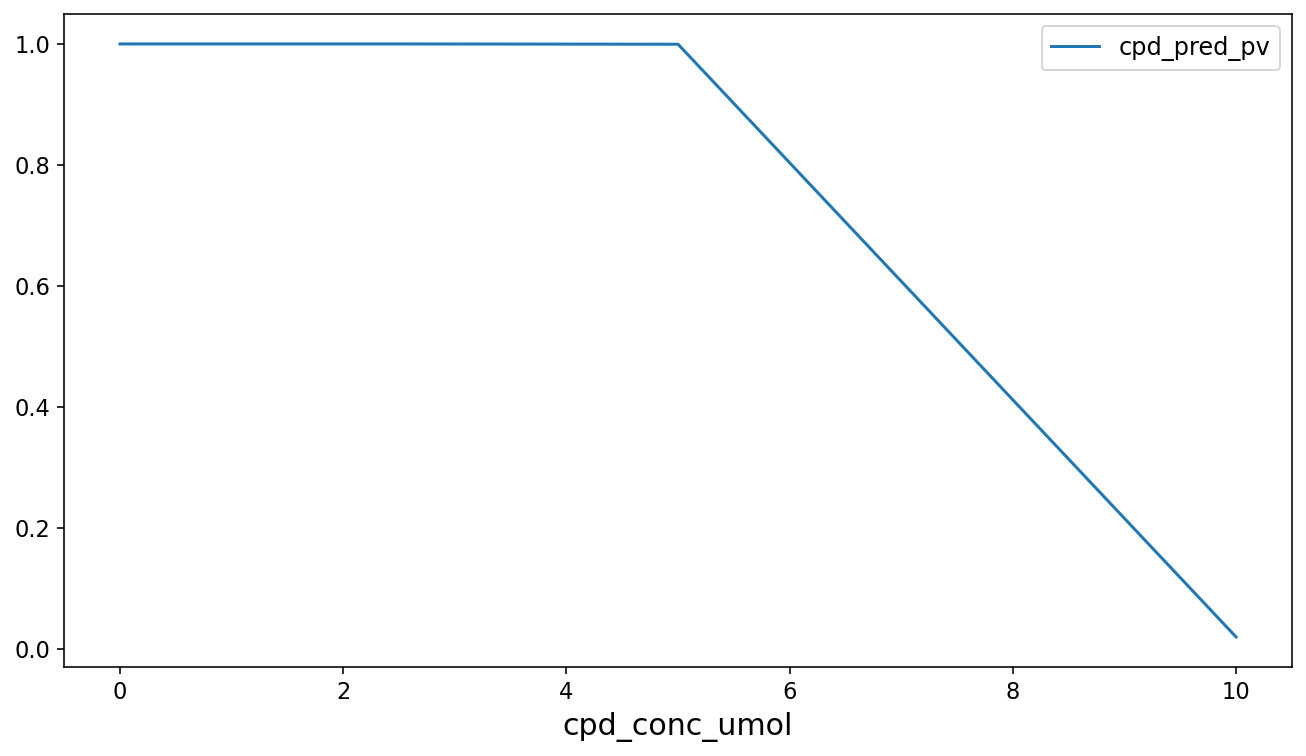

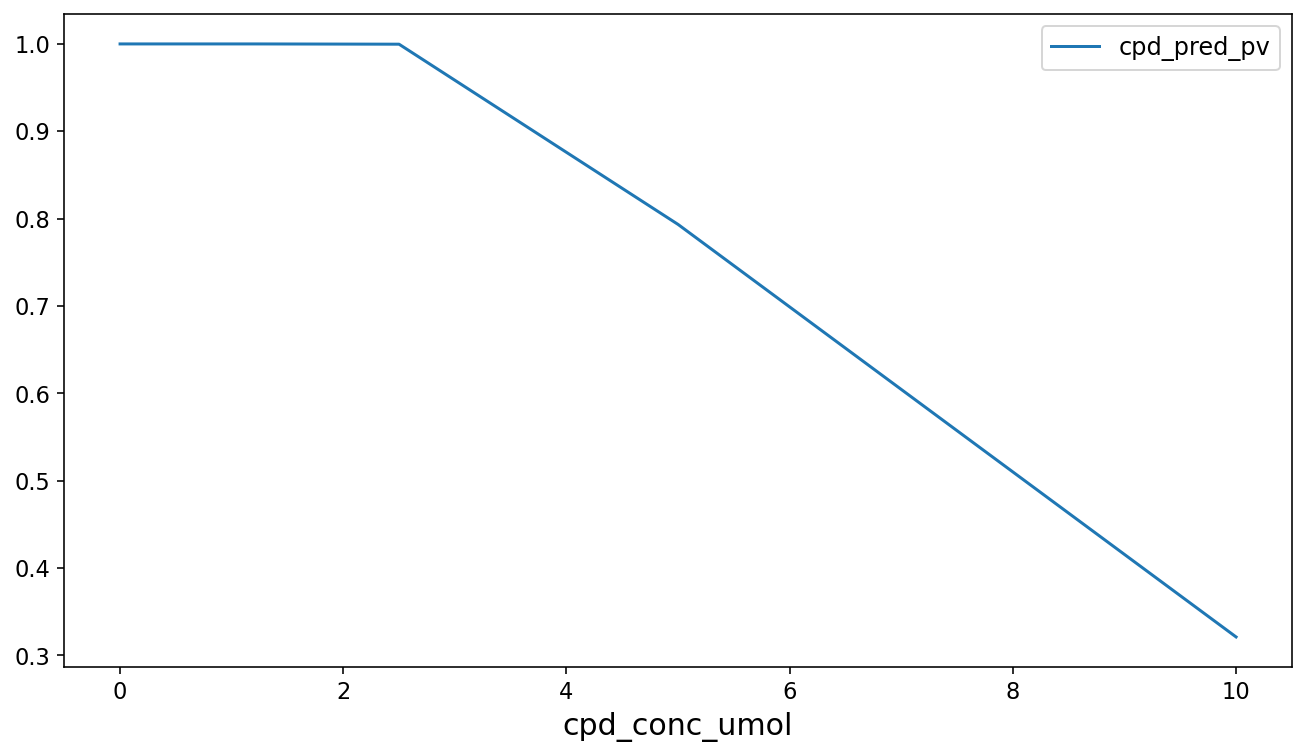

In [32]:
ctrp[ctrp['master_cpd_id']==1788].loc[1].plot('cpd_conc_umol', 'cpd_pred_pv')
ctrp[ctrp['master_cpd_id']==1788].loc[10].plot('cpd_conc_umol', 'cpd_pred_pv')

## Read Data

In [81]:
exp = 'multifilm'
fold = 0

In [82]:
dataset, input_cols, cond_cols = prepare(exp, subset=True)
cols = list(np.concatenate((input_cols, cond_cols, ['cpd_pred_pv']))) 

In [83]:
train = dataset.to_table(columns=cols, filter=ds.field('fold') != fold).to_pandas()
val = dataset.to_table(columns=cols, filter=ds.field('fold') == fold).to_pandas()

In [84]:
dm = CTRPDataModule(train,
                    val,
                    input_cols,
                    cond_cols,
                    target='cpd_pred_pv',
                    batch_size=32768)

In [85]:
dm.setup(stage='fit')

(<project.datasets.Dataset at 0x7fb8e5827dc0>,
 <project.datasets.Dataset at 0x7fb8e5827fd0>)

##### MetaData

In [86]:
meta_data = dataset.to_table(columns=['master_cpd_id', 'cpd_conc_umol', 'cpd_pred_pv', 'cpd_avg_pv', 'stripped_cell_line_name'], filter=ds.field('fold') == fold).to_pandas()

In [87]:
meta_val_cpd = dataset.to_table(columns=['master_cpd_id', 'cpd_conc_umol', 'cpd_pred_pv', 'cpd_avg_pv'], filter=ds.field('fold') == fold).to_pandas()
meta_val_line = dataset.to_table(columns=['stripped_cell_line_name'], filter=ds.field('fold') == fold).to_pandas()

In [88]:
_, cpd_idx = np.unique(meta_val_cpd[['master_cpd_id', 'cpd_conc_umol']], return_index=True, axis=0)
meta_val_cpd = meta_val_cpd.iloc[cpd_idx, :].set_index('master_cpd_id')
meta_val_cpd['log_cpd_conc'] = np.log1p(meta_val_cpd['cpd_conc_umol'])

_, line_idx = np.unique(meta_val_line, return_index=True)
meta_val_line = meta_val_line.iloc[line_idx, :].set_index('stripped_cell_line_name')

In [89]:
print(meta_val_cpd.shape)
print(meta_val_line.shape)

(8852, 4)
(166, 0)


##### Compound target data

In [90]:
ds_path = Path("../../film-gex-data/drug_screens/")
cp_ctrp = pd.read_csv(ds_path.joinpath("CTRP/v20.meta.per_compound.txt"), sep="\t", index_col=0)

In [91]:
meta_val_cpd = meta_val_cpd.join(cp_ctrp)

In [92]:
from scipy.optimize import curve_fit
from scipy.stats import logistic

In [93]:
def ll4(x,b,c,d,e):
    '''This function is basically a copy of the LL.4 function from the R drc package with
     - b: hill slope
     - c: min response
     - d: max response
     - e: EC50'''
    return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))

Text(0.5, 1.0, 'Erlotinib')

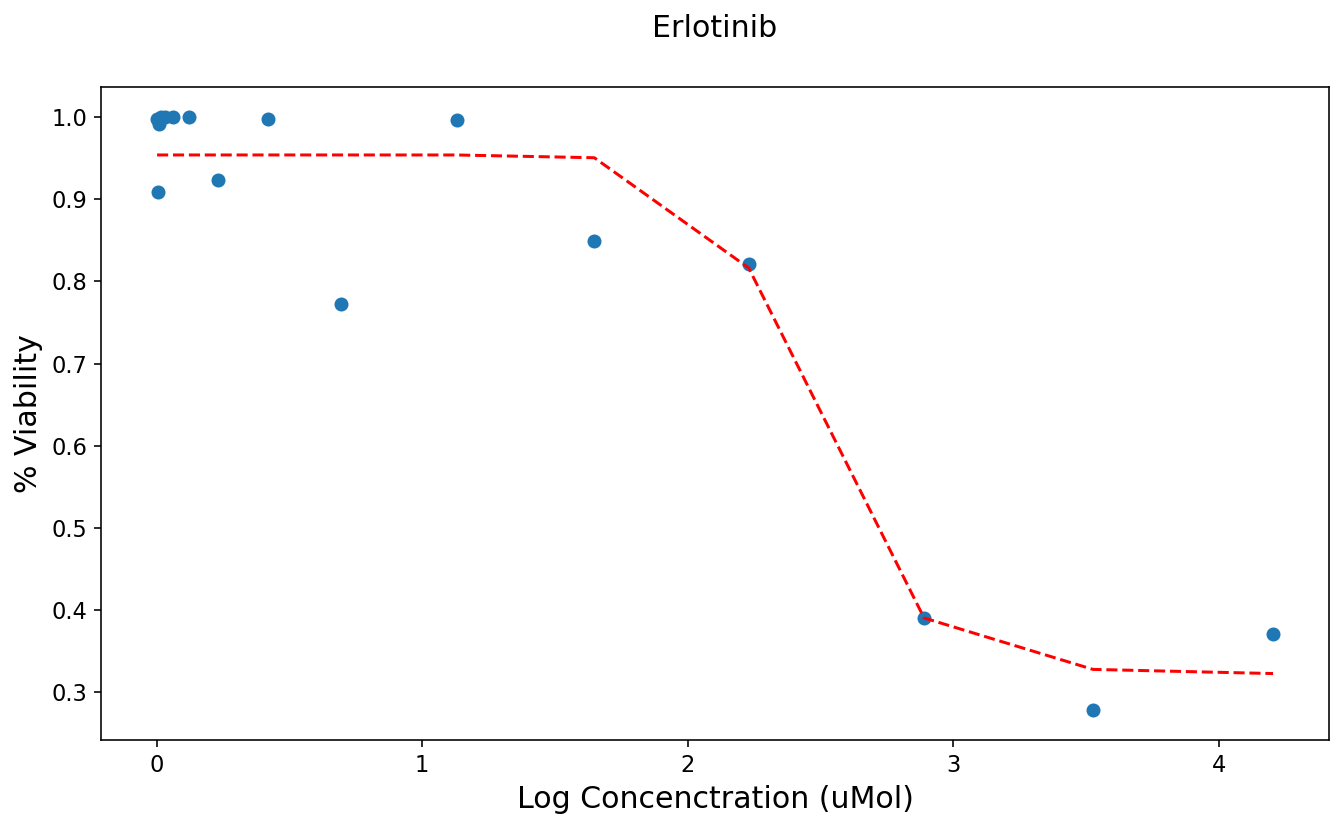

In [94]:
x = meta_val_cpd[meta_val_cpd['cpd_name']=='erlotinib']['log_cpd_conc'].values
y = meta_val_cpd[meta_val_cpd['cpd_name']=='erlotinib']['cpd_pred_pv'].values
popt, pcov = curve_fit(ll4, x, y)
plt.plot(x, y, ".", ms=12)
plt.plot(x, ll4(x, *popt), 'r--')

plt.xlabel('Log Concenctration (uMol)')
plt.ylabel('% Viability')
plt.title('Erlotinib')

Text(0.5, 1.0, 'Sirolimus')

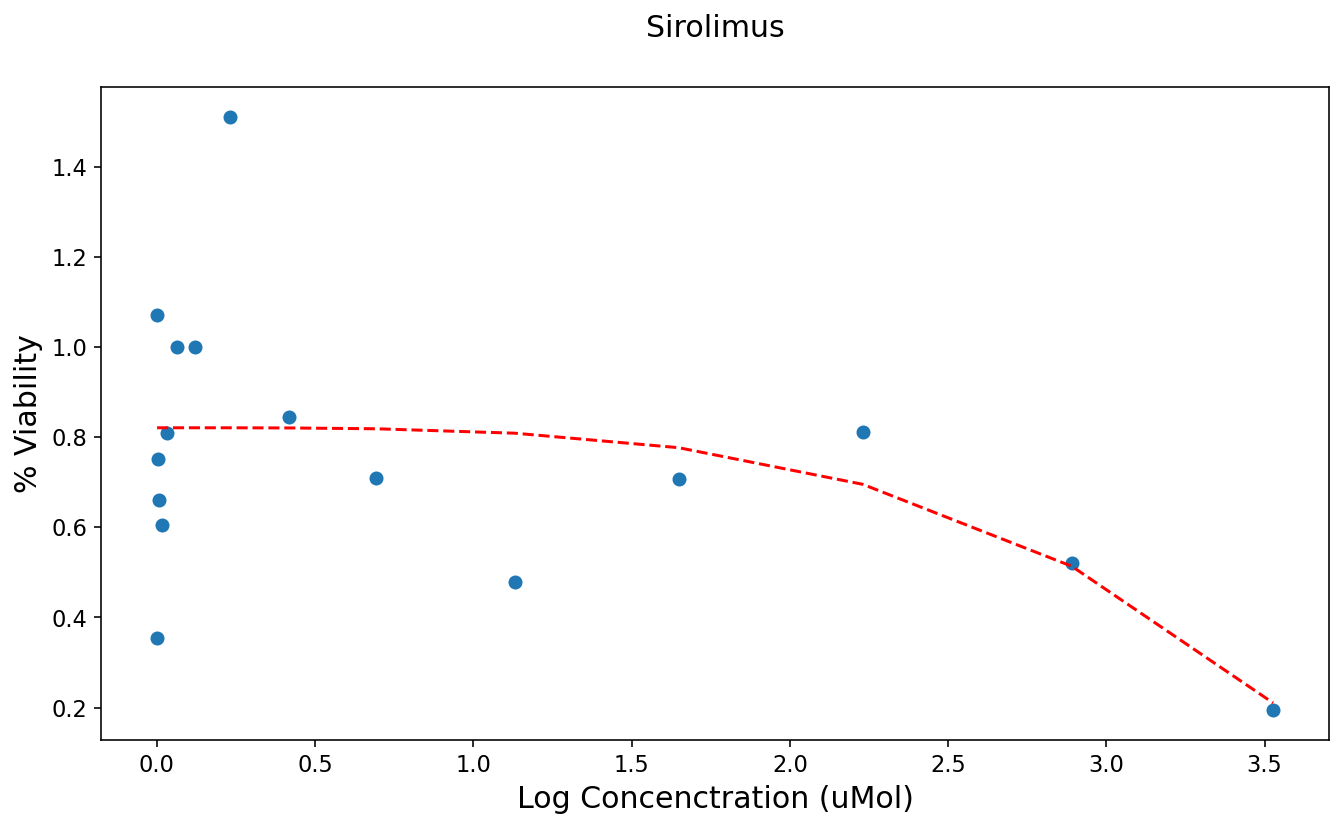

In [95]:
x = meta_val_cpd[meta_val_cpd['cpd_name']=='sirolimus']['log_cpd_conc'].values
y = meta_val_cpd[meta_val_cpd['cpd_name']=='sirolimus']['cpd_pred_pv'].values
popt, pcov = curve_fit(ll4, x, y)
plt.plot(x, y, ".", ms=12)
plt.plot(x, ll4(x, *popt), 'r--')
plt.xlabel('Log Concenctration (uMol)')
plt.ylabel('% Viability')
plt.title('Sirolimus')

### Load Model

In [96]:
ls /scratch/disk2/wconnell/film-gex-data/lightning_logs/full-bias_bias_fold_0/checkpoints/

epoch=9.ckpt


In [97]:
model_dir = "/scratch/disk2/wconnell/film-gex-data/lightning_logs/"
film_model = MultiFiLMNetwork.load_from_checkpoint(os.path.join(model_dir, "full-mf_multifilm_fold_0/checkpoints/epoch=9.ckpt"))
concat_model = ConcatNetwork.load_from_checkpoint(os.path.join(model_dir, "full-bias_bias_fold_0/checkpoints/epoch=9.ckpt"))
film_model.freeze()
concat_model.freeze()

In [98]:
# load proceessed data (stdscaled)
inputs, conds, y = dm.val_dataset[:]

In [99]:
conds_uq = conds[cpd_idx]
inputs_uq = inputs[line_idx]

In [100]:
# film emb
film_inputs_emb = film_model.inputs_emb(inputs_uq)
film_conds_emb = film_model.conds_emb(conds_uq)

In [101]:
# concat emb
concat_inputs_emb = concat_model.inputs_emb(inputs_uq)
concat_conds_emb = concat_model.conds_emb(conds_uq)

## Prediction Evaluation

In [102]:
inputs_emb, conds_a_emb, conds_b_emb, y_hat = film_model(inputs, conds, conds)

In [103]:
preds = pd.DataFrame({'y':y,
                      'y_hat':y_hat.squeeze().numpy()})

In [104]:
preds.describe()

y          y_hat
count  116249.000000  116249.000000
mean        0.847850       0.870278
std         0.279781       0.236718
min         0.000000       0.000000
25%         0.832700       0.816342
50%         0.995300       0.957002
75%         1.000000       1.002151
max         1.845000       2.769155

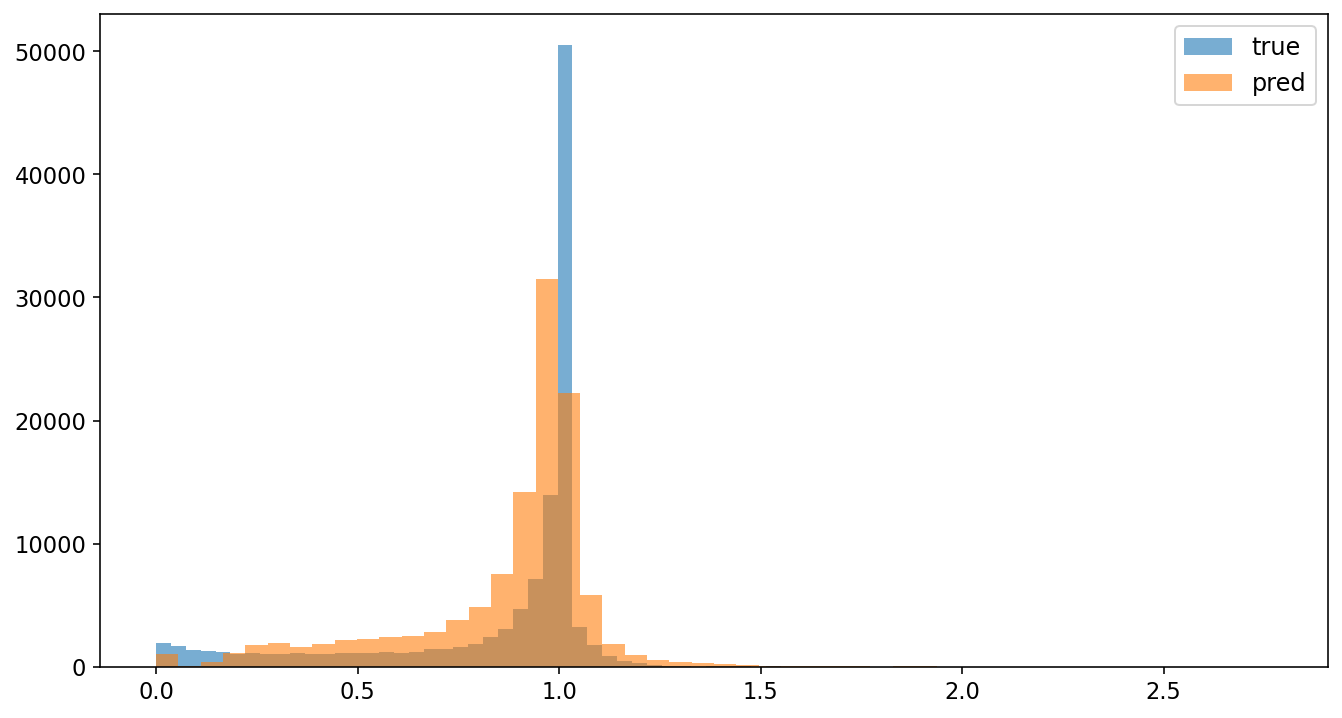

In [105]:
plt.hist(preds['y'], alpha=0.6, label='true', bins=50)
plt.hist(preds['y_hat'], alpha=0.6, label='pred', bins=50)
plt.legend()

#### Predict over concentration range

In [238]:
query_idx = np.where(meta_val_cpd['cpd_name']=='erlotinib')[0]

In [242]:
conds_uq[query_idx].shape

torch.Size([16, 513])

In [241]:
meta_val_line

Empty DataFrame
Columns: []
Index: [639V, A204, A4FUK, A549, BFTC905, BFTC909, BICR16, BICR18, BL41, BXPC3, C32, CA46, CAKI1, CAL27, CAL51, CAL54, CAL78, CALU6, CFPAC1, CHAGOK1, CL11, COLO699, CORL47, COV434, DMS114, DMS79, EFO21, EN, EOL1, G361, GA10, GP2D, GSS, HCC1428, HCC1500, HCC2108, HCC33, HCT116, HEC108, HEC1A, HEC265, HEP3B217, HEPG2, HEYA8, HLF, HMCB, HOS, HPAC, HPAFII, HS888T, HS895T, HSC3, HT1197, HT144, HUCCT1, ISTMES1, JEKO1, JHH6, JHOC5, JHUEM1, JHUEM2, JJN3, KM12, KMRC20, KMS26, KNS42, KPNSI9S, KU812, L1236, L33, L363, LCLC103H, LK2, LOUNH91, LOVO, LS1034, LS411N, LUDLU1, MELJUSO, MESSA, MFE319, MM1S, MOLM6, MOLP2, NALM6, NCIH1092, NCIH1563, NCIH1975, NCIH2085, NCIH209, NCIH2106, NCIH211, NCIH2171, NCIH2228, NCIH226, NCIH28, NCIH441, NCIH522, NCIH660, NCIH716, ...]

[166 rows x 0 columns]

In [ ]:
film_model

## FiLM Parameter Analysis

In [106]:
film1_gamma, film1_beta = film_model.film_1(film_conds_emb)
film2_gamma, film2_beta = film_model.film_2(film_conds_emb)

In [107]:
from sklearn.manifold import TSNE

### Film 1

In [118]:
# First Film Layer
tsne = TSNE()
film1_tsne = tsne.fit_transform(torch.cat([film1_gamma, film1_beta]).numpy())

film1_params = pd.concat([meta_val_cpd.copy(), meta_val_cpd.copy()])
film1_params['Parameter'] = np.concatenate((np.repeat('gamma', len(film1_gamma)), np.repeat('beta', len(film1_beta))))
film1_params['TSNE_0'] = film1_tsne[:,0]
film1_params['TSNE_1'] = film1_tsne[:,1]

<AxesSubplot:xlabel='TSNE_0', ylabel='TSNE_1'>

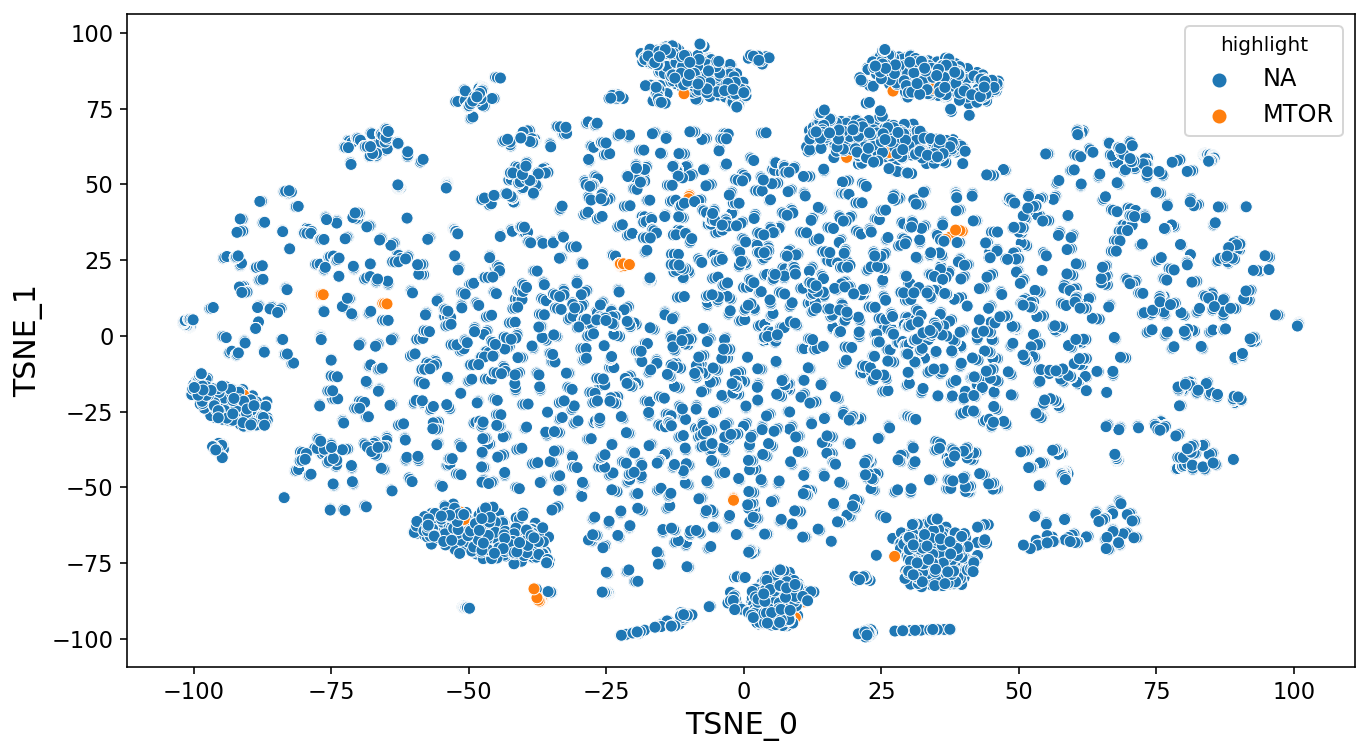

In [217]:
query = 'MTOR'
col = 'gene_symbol_of_protein_target'
film1_params['highlight'] = np.where(film1_params[col]==query, query, 'NA')
sns.scatterplot(x='TSNE_0', y='TSNE_1', hue='highlight', data=film1_params)

<AxesSubplot:xlabel='TSNE_0', ylabel='TSNE_1'>

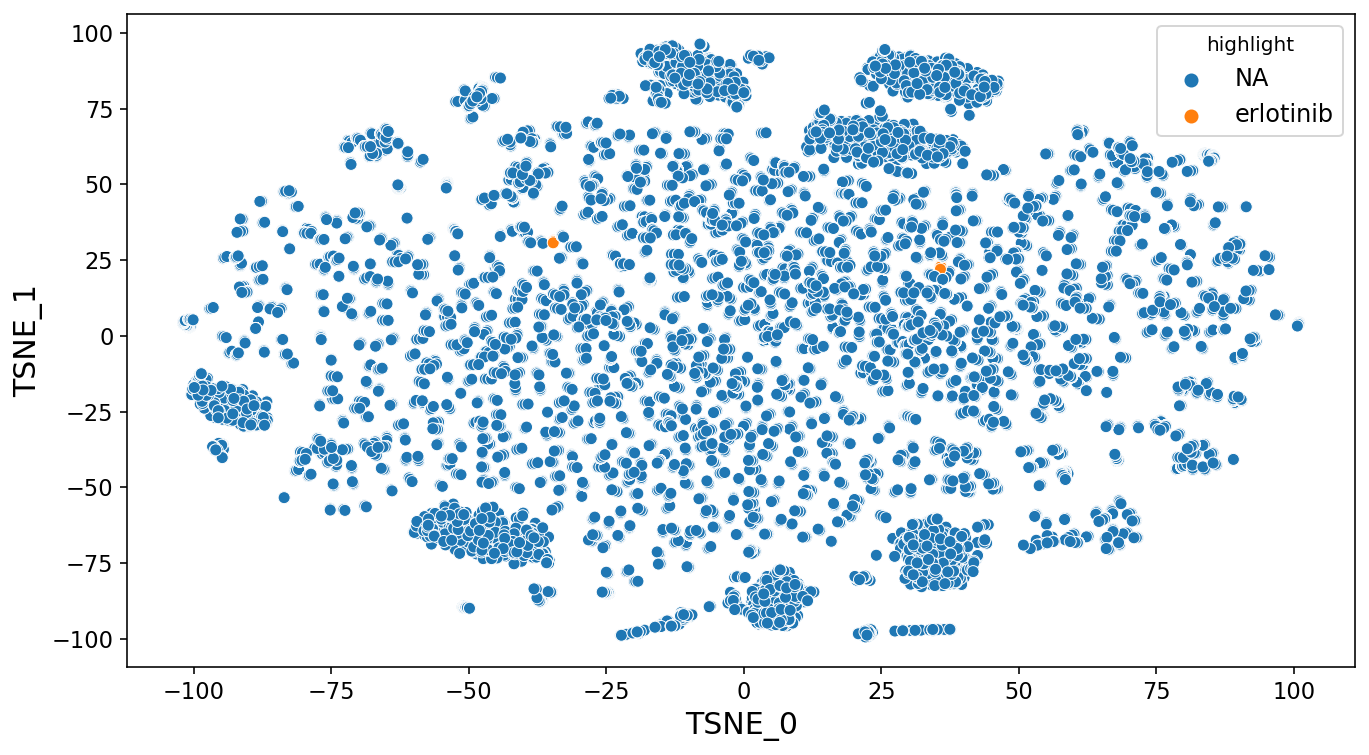

In [222]:
query = 'erlotinib'
col = 'cpd_name'
film1_params['highlight'] = np.where(film1_params[col]==query, query, 'NA')
sns.scatterplot(x='TSNE_0', y='TSNE_1', hue='highlight', data=film1_params)

<AxesSubplot:xlabel='TSNE_0', ylabel='TSNE_1'>

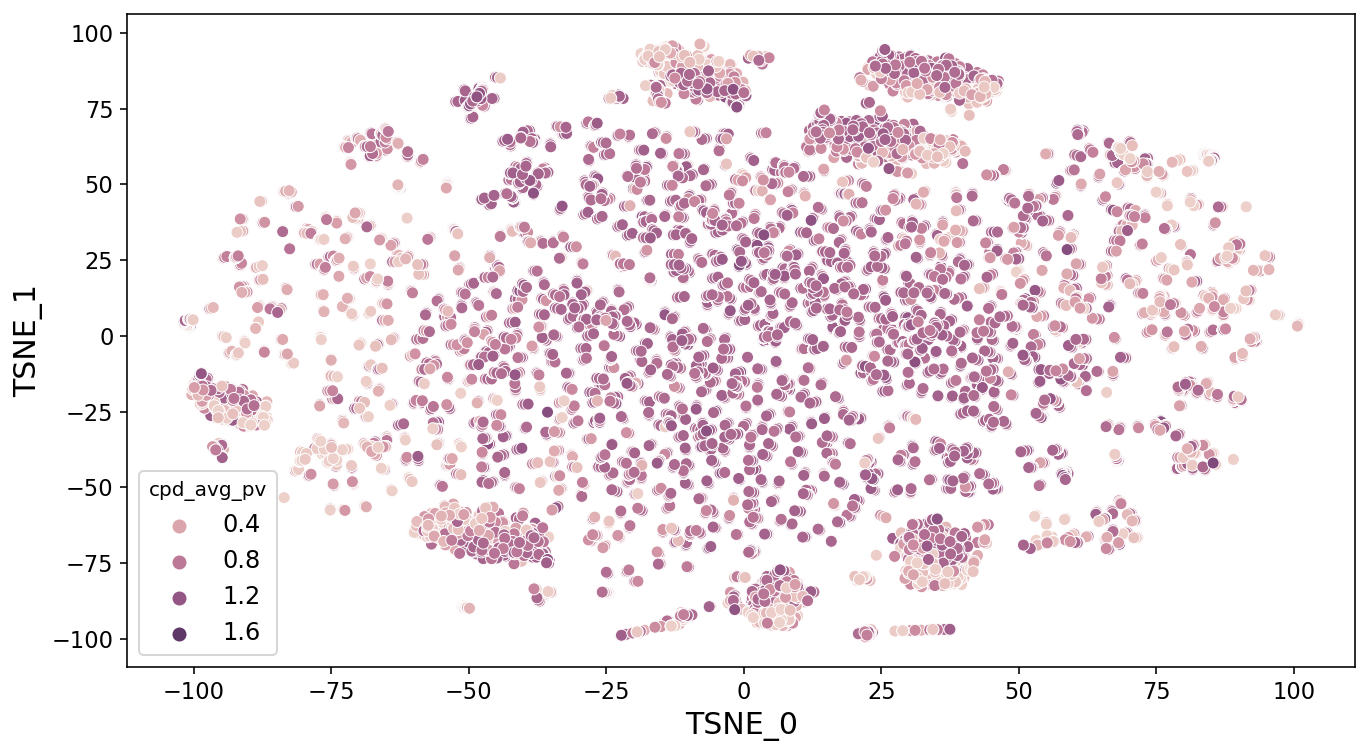

In [214]:
sns.scatterplot(x='TSNE_0', y='TSNE_1', hue='cpd_avg_pv', data=film1_params)

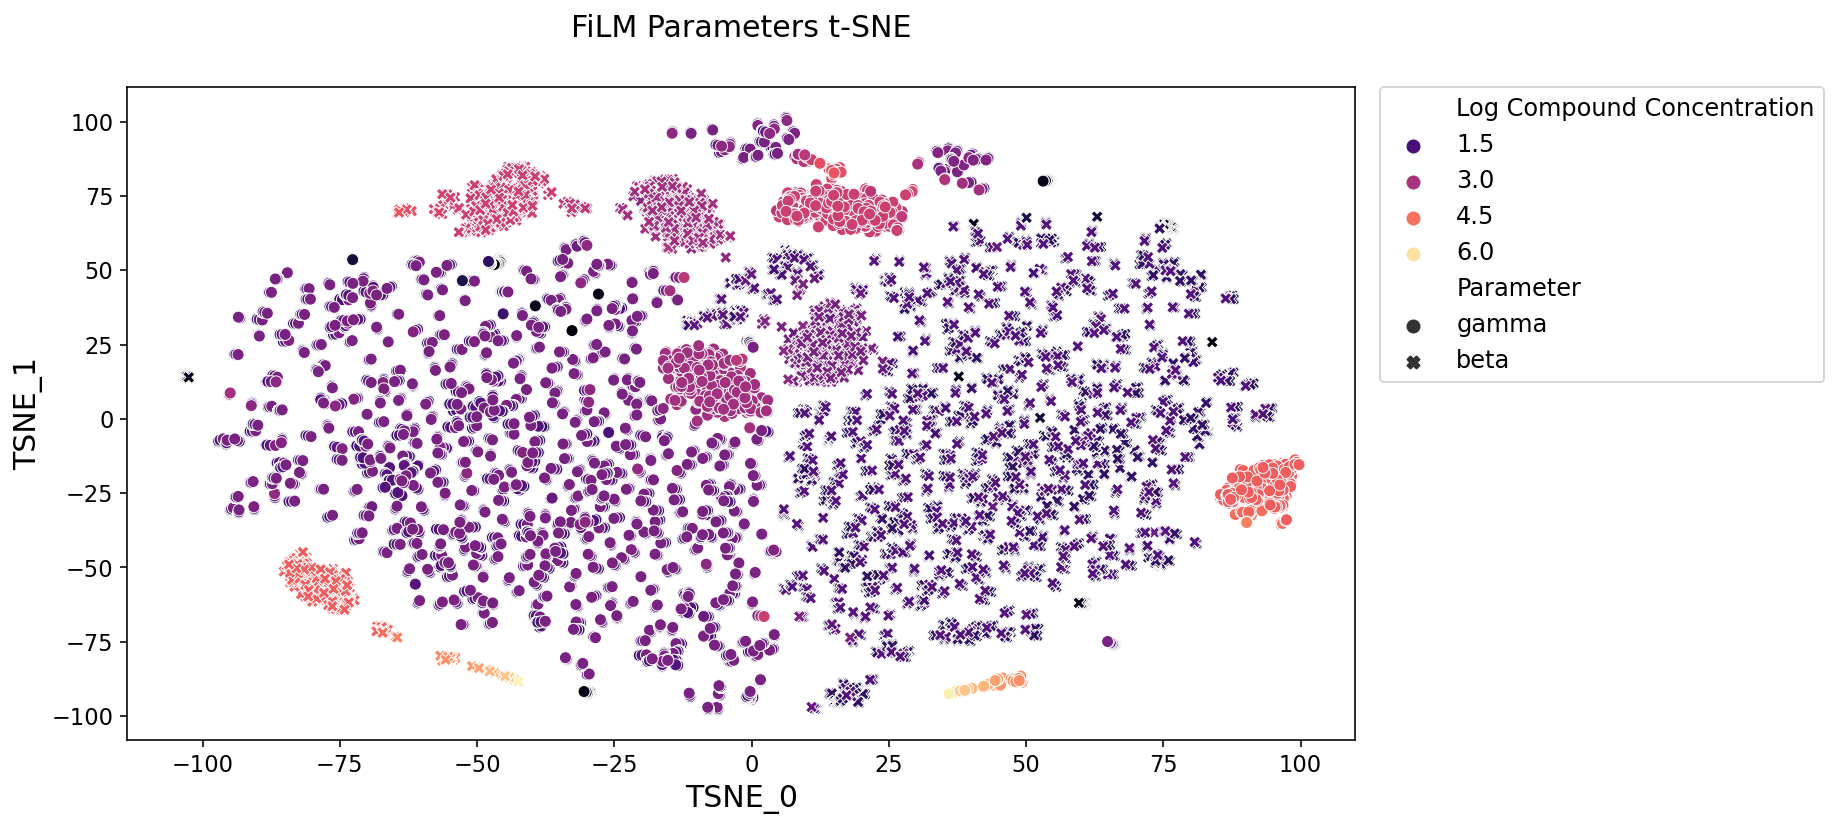

<Figure size 720x720 with 0 Axes>

In [139]:
film1_params = film1_params.rename(columns={'log_cpd_conc': 'Log Compound Concentration'})
g = sns.scatterplot(x='TSNE_0', y='TSNE_1', hue='Log Compound Concentration', style='Parameter', palette='magma', data=film1_params)
g.set_title('FiLM Parameters t-SNE')
g.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.figure(figsize=(10,10))
plt.show()

### Film 2

In [ ]:
# Second Film Layer
tsne = TSNE()
film2_tsne = tsne.fit_transform(torch.cat([film2_gamma, film2_beta]).numpy())

film2_params = pd.concat([meta_val_cpd.copy(), meta_val_cpd.copy()])
film2_params['param'] = np.concatenate((np.repeat('gamma', len(film2_gamma)), np.repeat('beta', len(film2_beta))))
film2_params['TSNE_0'] = film2_tsne[:,0]
film2_params['TSNE_1'] = film2_tsne[:,1]
film2_params['log_cpd_conc'] = np.log1p(film2_params['cpd_conc_umol'])

Text(0.5, 1.0, 'Second FiLM Parameters')

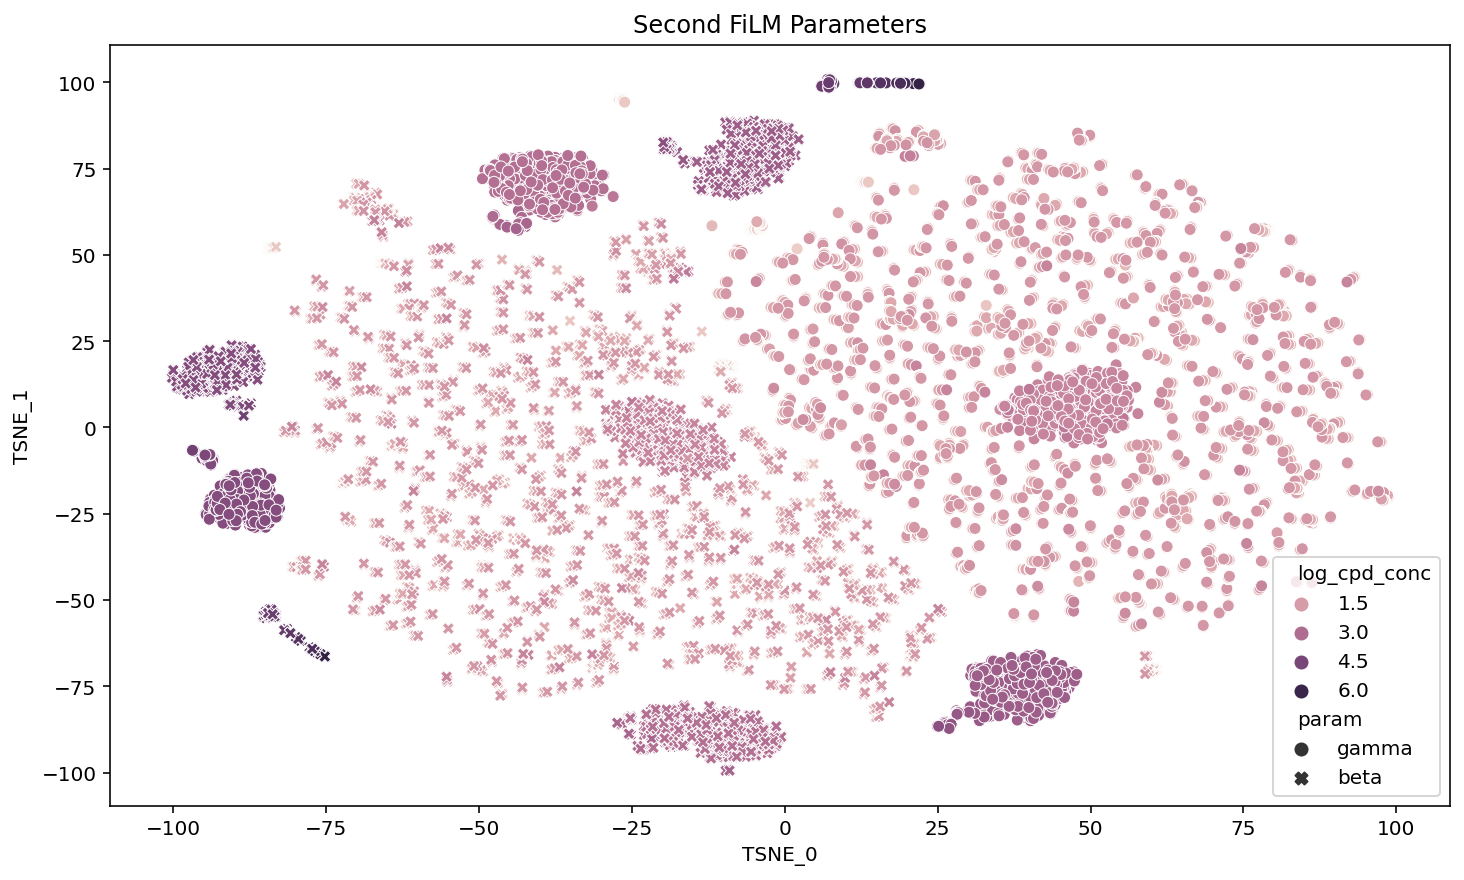

In [356]:
sns.scatterplot(x='TSNE_0', y='TSNE_1', hue='log_cpd_conc', style='param', data=film2_params)
plt.title('Second FiLM Parameters')

### Concat Embedding Analysis

In [223]:
tnse = TSNE()
conds_tsne = tnse.fit_transform(concat_conds_emb.numpy())

tnse = TSNE()
inputs_tsne = tnse.fit_transform(concat_inputs_emb.numpy())

<AxesSubplot:>

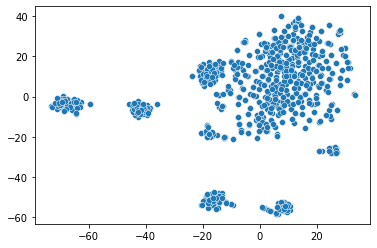

In [224]:
sns.scatterplot(x=conds_tsne[:,0], y=conds_tsne[:,1])

### Logs

In [1]:
from tensorboard.backend.event_processing import event_accumulator

In [2]:
def ea_to_df(path, metric):
    for i in os.listdir(path):
        if os.path.isfile(os.path.join(path,i)) and 'events.out.tfevents' in i:
            ea = event_accumulator.EventAccumulator(os.path.join(path, i))
            ea.Reload()
            _, step, value = zip(*ea.Scalars(metric))
            name, model, _, fold = os.path.split(path)[1].split("_")
            df = pd.DataFrame({'name': np.repeat(name, len(step)),
                               'model': np.repeat(model, len(step)),
                               'fold': np.repeat(fold, len(step)),
                               'epoch': np.arange(1, len(step)+1),
                               'step': step,
                               metric: value})
    return df

In [72]:
def plt_metric(names, metric, bound, **kwargs):
    path = Path("/scratch/disk2/wconnell/film-gex-data/lightning_logs/")
    df = pd.concat([ea_to_df(path.joinpath(p), metric) for p in os.listdir(path)])
    df = df[df['name'].isin(names.keys())]
    # averages
    df_avg = df.groupby(['name', 'epoch']).mean().reset_index()
    if bound=='min':
        df_best = df_avg.groupby(['name']).min()
    elif bound=='max':
        df_best = df_avg.groupby(['name']).max()
    # plot
    g = sns.lineplot(x='epoch', y=metric, hue='name', data=df, legend=True, ci=25)
    # legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend(loc='lower right')
    for i,txt in enumerate(g.legend_.texts):
        val = df_best.loc[txt.get_text()][metric]
        g.legend_.texts[i].set_text(f"{names[txt.get_text()]} = {val:.4f}")# Put the legend out of the figure
    plt.ylim(kwargs['ylim'])
    plt.xlabel('Epoch')
    g.set_xticks(df['epoch'].unique())
    g.set_xticklabels(df['epoch'].unique())
    plt.ylabel(kwargs['ylabel'])
    g.set_title(f"{kwargs['title']}, 5-Fold CV")
    plt.show(g)

In [61]:
names = ['full-sf', 'full-mf', 'full-bias', 'full-scale', 'full-id']
names = ['full-mf', 'full-bias', 'full-scale', 'full-id']
names = {'full-mf': 'FiLM',
         'full-bias': 'Bias',
         'full-scale': 'Scale',
         'full-id': 'ID'}

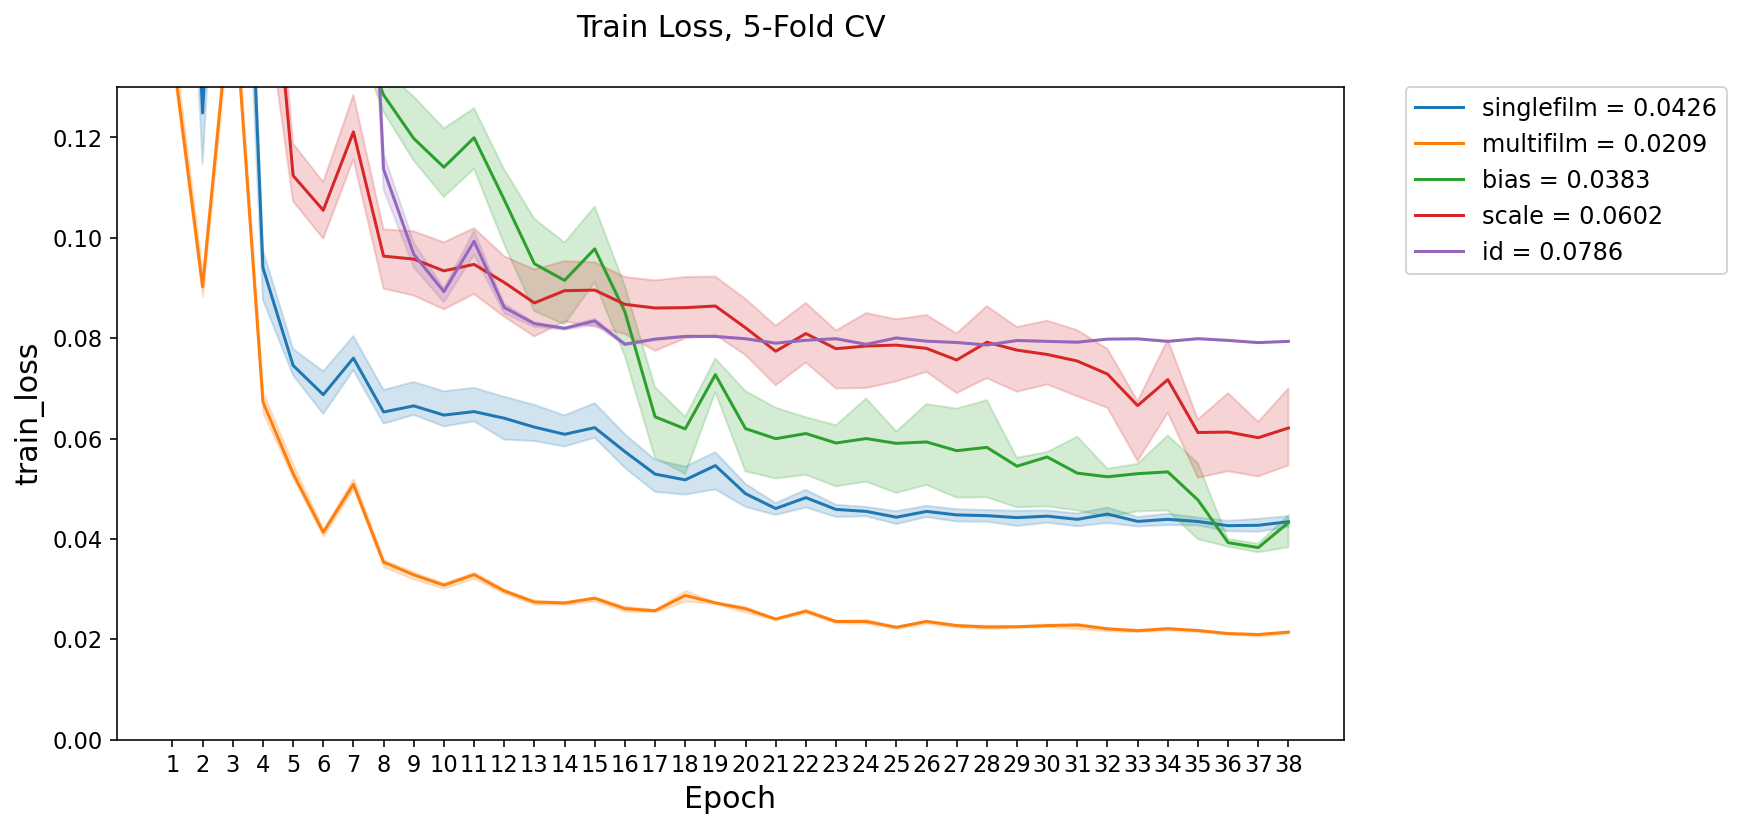

In [56]:
plt_metric(names, 'train_loss', 'min', ylim=(0,0.13), title='Train Loss')

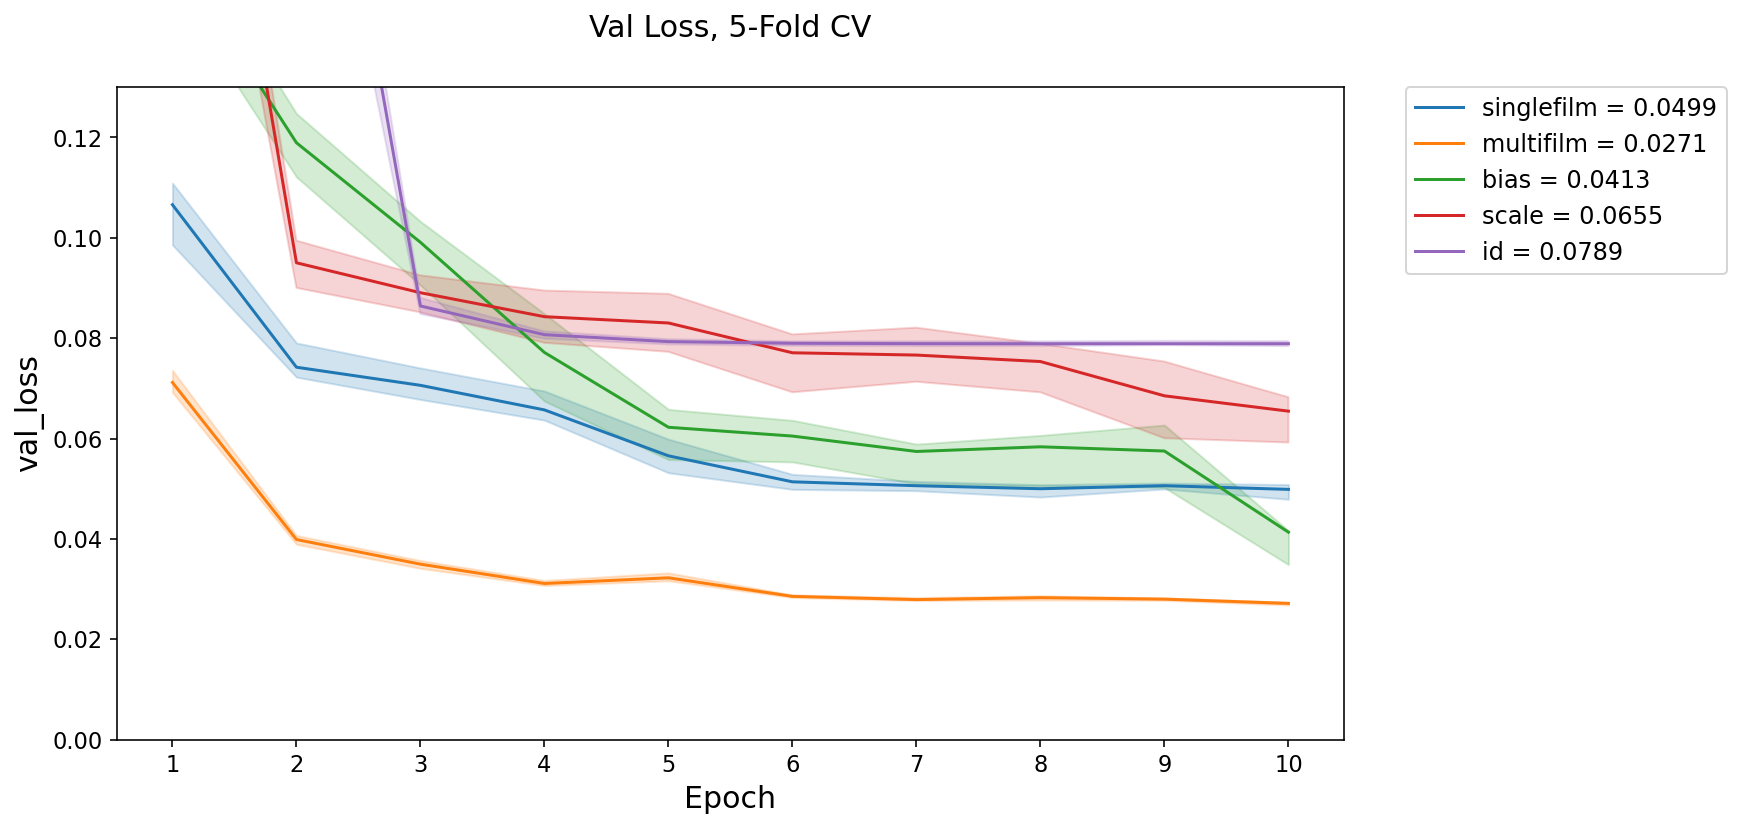

In [57]:
plt_metric(names, 'val_loss', 'min', ylim=(0,0.13), title='Val Loss')

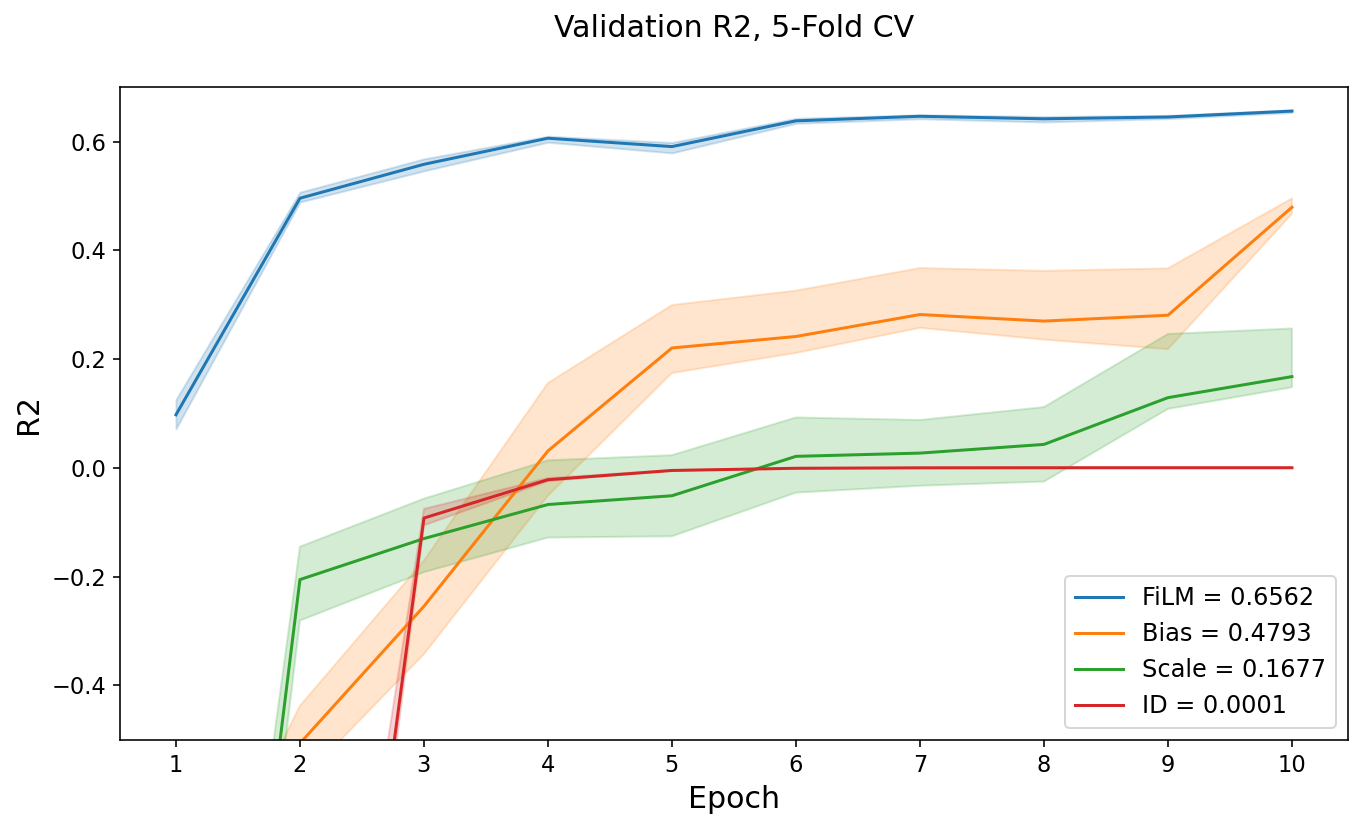

In [73]:
plt_metric(names, 'val_r2', 'max', ylabel='R2', ylim=(-0.50,0.7), title='Validation R2')